In [1]:
import pandas as pd
import re
import os
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df = pd.read_csv("logbook_assignment1.csv", dtype=str, encoding='utf-8', low_memory=False)
df.info()
df.head()
OUTPUT_PLOTS_DIR = "plots_numeric"
os.makedirs(OUTPUT_PLOTS_DIR, exist_ok=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174870 entries, 0 to 1174869
Data columns (total 9 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   date_fueled      1125665 non-null  object
 1   date_captured    1174870 non-null  object
 2   odometer         1025716 non-null  object
 3   gallons          1100660 non-null  object
 4   cost_per_gallon  1094110 non-null  object
 5   total_spent      1100660 non-null  object
 6   mpg              1100660 non-null  object
 7   miles            146274 non-null   object
 8   user_url         1174870 non-null  object
dtypes: object(9)
memory usage: 80.7+ MB


In [2]:
#1.1 Cleaning:Date Fields
from dateutil.parser import parse
import warnings
from dateutil.parser._parser import UnknownTimezoneWarning

warnings.filterwarnings("ignore", category=UnknownTimezoneWarning)

#returns true if the entry is in a date format 
def validdate(s):
    if not isinstance(s, str) or not s.strip():
        return False
    try:
        parse(s, dayfirst=False,yearfirst=False,fuzzy=False)
        return True
    except Exception:
        return False

total = len(df)
invalid = (~df["date_fueled"].map(validdate)).sum()
invalidtotal= (invalid / total) * 100
print(f"Total dates: {total}")
print(f"Invalid dates: {invalid}")
print(f"Percentage of invalid dates: {invalidtotal:.3f}%")


Total dates: 1174870
Invalid dates: 135137
Percentage of invalid dates: 11.502%


In [3]:
#1.2

fueled_list = df["date_fueled"].astype(str).tolist() #convert the 'date_fueled' column to a list of strings
captured_list = df["date_captured"].astype(str).tolist()
#keeps track of how many rows we fix
replaced_count = 0

for i in range(len(fueled_list)):
    if not validdate(fueled_list[i]):    #check if current fueled val is invalid
        if validdate(captured_list[i]):      #if fueled is invalid, check if captured is valid
            fueled_list[i] = captured_list[i]    #If captured is valid, replace fueled with captured/replace with proxy 
            replaced_count += 1 #increase the counter since we fixed one row
#update the DataFrame with the fixed fueled_lis
df["date_fueled"] = fueled_list

print(f"Rows filled from date_captured: {replaced_count}") #replacements made
print("valid fueled:", df["date_fueled"].map(validdate).sum()) #entries in the final date_fueled column are valid
print("valid captured:", df["date_captured"].map(validdate).sum())#entries in the date_captured column are valid




Rows filled from date_captured: 135137
valid fueled: 1174870
valid captured: 1174870


In [4]:
#1.3

df["date_fueled_dt"] = pd.to_datetime(df["date_fueled"], errors="coerce", dayfirst=False)

#count invalids (NaT)
total = len(df)
nat_count = df["date_fueled_dt"].isna().sum()
print(f"entries converted to NaT: {nat_count} ({nat_count/total:.2%})")




entries converted to NaT: 2073 (0.18%)


In [5]:

# #remove later
# mask_validator_ok = df["date_fueled"].map(validdate)
# mask_pandas_nat   = df["date_fueled_dt"].isna()
# off_by_pandas = df.loc[mask_validator_ok & mask_pandas_nat, "date_fueled"].head(20)
# print("Validator OK but pandas NaT (samples):")
# print(off_by_pandas.to_list())

# print(df.loc[mask_validator_ok & mask_pandas_nat, "_date_fueled_raw"].head(20).to_list())


# print({
#     "validator_invalid": int((~mask_validator_ok).sum()),
#     "pandas_NaT": int(mask_pandas_nat.sum()),
#     "validator_ok_but_pandas_NaT": int((mask_validator_ok & mask_pandas_nat).sum())
# })


In [6]:
#1.4
lower = pd.Timestamp("2005-01-01")
upper= pd.Timestamp.today().normalize()  #today's date

#True if inside the valid range)
mask = df["date_fueled_dt"].between(lower, upper, inclusive="both")

#filter the dataframe
before = len(df)
df = df[mask].copy()
after = len(df)

#many were dropped
print(f"Removed rows outside [{lower.date()} .. {upper.date()}]: {before - after}")
print(f"Rows remaining: {after}")




Removed rows outside [2005-01-01 .. 2025-09-04]: 2643
Rows remaining: 1172227


Date range (after cleaning): 2005–2025
Peak year: 2021  (count = 340217)
Share of records in the last 5 years: 45.1%
Most common month number: 3 (1=Jan, 12=Dec)


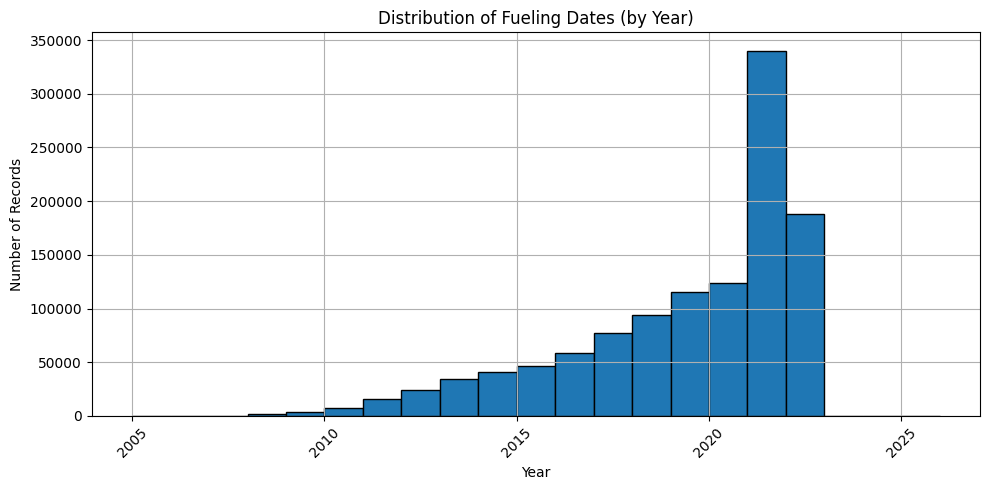

In [7]:
#1.5
import pandas as pd
import matplotlib.pyplot as plt

#Make sure we have a datetime column
DATE_COL = "date fueled" if "date fueled" in df.columns else "date_fueled"
if "date_fueled_dt" not in df.columns:
    df["date_fueled_dt"] = pd.to_datetime(df[DATE_COL], errors="coerce", dayfirst=False)

#keep only valid datetimes
dates = df["date_fueled_dt"].dropna()

years = dates.dt.year
months = dates.dt.month

year_counts = years.value_counts().sort_index()
month_counts = months.value_counts().sort_index()

start_year = int(years.min()) if not years.empty else None
end_year   = int(years.max()) if not years.empty else None

top_year = int(year_counts.idxmax()) if not year_counts.empty else None
top_year_n = int(year_counts.max()) if not year_counts.empty else 0

#last 5 yrs
if not years.empty:
    last5_mask = years >= (years.max() - 4)
    share_last5 = last5_mask.mean() * 100
else:
    share_last5 = 0.0

peak_month = int(month_counts.idxmax()) if not month_counts.empty else None
print(f"Date range (after cleaning): {start_year}–{end_year}")
print(f"Peak year: {top_year}  (count = {top_year_n})")
print(f"Share of records in the last 5 years: {share_last5:.1f}%")
print(f"Most common month number: {peak_month} (1=Jan, 12=Dec)")


if not years.empty:
    plt.figure(figsize=(10, 5))
    # use integer bins from min to max (+1 to close the last bin)
    bins = range(int(years.min()), int(years.max()) + 2)
    years.hist(bins=bins, edgecolor="black")
    plt.title("Distribution of Fueling Dates (by Year)")
    plt.xlabel("Year")
    plt.ylabel("Number of Records")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()




In [10]:
#1.2 Helper Functions
def clean_numeric_series(s: pd.Series) -> pd.Series:
    """Remove common non-numeric characters and convert to float.

    Handles: commas (thousand separators), currency symbols, spaces,
    parentheses for negatives, and empty strings. Returns a float Series
    with NaN where conversion fails.
    """
    # Work on a string copy and guard for non-strings
    s2 = s.astype(str).str.strip()
    # Replace non-breaking spaces
    s2 = s2.str.replace(r" ", "", regex=True)
    # Remove currency symbols and thousands separators
    s2 = s2.str.replace(r"[,$£€¥]", "", regex=True)
    # Detect parentheses representing negatives
    has_paren = s2.str.startswith("(") & s2.str.endswith(")")
    # Remove parentheses and any stray characters except - . e digits
    s2 = s2.str.replace(r"[()]", "", regex=True)
    s2 = s2.str.replace(r"[^0-9.\-eE]", "", regex=True)
    # Treat blanks / "nan" strings as missing
    s2 = s2.replace({'': None, 'None': None, 'nan': None, 'NaN': None})
    out = pd.to_numeric(s2, errors='coerce')
    # Reapply negative sign where parentheses existed
    if has_paren.any():
        out.loc[has_paren] = -out.loc[has_paren].abs()
    return out


def percent_missing(df: pd.DataFrame, columns: list) -> pd.Series:
    return df[columns].isna().mean() * 100

In [16]:
# --- 1.2: Numeric cleaning (drop-in) ---

import numpy as np

# Use the robust cleaner you defined (it removes currency, text, parentheses, etc.)
NUMERIC_COLS = [c for c in ['miles','gallons','mpg','odometer'] if c in df.columns]
for col in NUMERIC_COLS:
    df[col] = clean_numeric_series(df[col])

# Basic plausibility filters: set impossible values to NaN before imputation
# Tune thresholds if your instructor provided different ranges.
if 'gallons' in df.columns:
    df.loc[(df['gallons'] <= 0) | (df['gallons'] > 80), 'gallons'] = np.nan  # >80 US gal is vanishingly rare
if 'mpg' in df.columns:
    df.loc[(df['mpg'] <= 0) | (df['mpg'] > 200), 'mpg'] = np.nan             # 200 mpg is not realistic for cars
if 'miles' in df.columns:
    df.loc[df['miles'] < 0, 'miles'] = np.nan                                # negative distance impossible

# (Optional) re-compute missingness after true numeric parsing
cols_for_missing = [c for c in ['gallons','miles','odometer'] if c in df.columns]
missing_pct_after = percent_missing(df, cols_for_missing)
print("Missing % AFTER numeric cleaning:")
print(missing_pct_after)


Missing % AFTER numeric cleaning:
gallons      6.422476
miles       87.599927
odometer    12.645503
dtype: float64


In [18]:
# --- 1.2.2: Algebraic imputation ---

derived_df = df.copy()   # working copy; leaves df intact

def plausible_miles(x):   return (x > 0) & (x < 2000)     # per fill-up (tweak if needed)
def plausible_gallons(x): return (x > 0.1) & (x < 50)     # typical car fill-up range
def plausible_mpg(x):     return (x > 3) & (x < 120)      # common road-vehicle range

def safe_div(num, den):
    """Elementwise division that returns NaN on divide-by-zero or non-finite."""
    out = num / den
    out[~np.isfinite(out)] = np.nan
    return out

# Iterate a few times until no more fills
for iteration in range(6):
    changed = False

    have = set(derived_df.columns)
    if not {'miles','gallons','mpg'}.issubset(have):
        break

    # Compute candidates
    mpg_calc     = safe_div(derived_df['miles'], derived_df['gallons'])
    miles_calc   = derived_df['mpg'] * derived_df['gallons']
    gallons_calc = safe_div(derived_df['miles'], derived_df['mpg'])

    # Fill mpg where missing and candidate is plausible
    m = (
        derived_df['mpg'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_mpg(mpg_calc)
    )
    if m.any():
        derived_df.loc[m, 'mpg'] = mpg_calc[m]
        changed = True

    # Fill miles where missing and candidate is plausible
    m = (
        derived_df['miles'].isna()
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(derived_df['gallons'])
        & plausible_miles(miles_calc)
    )
    if m.any():
        derived_df.loc[m, 'miles'] = miles_calc[m]
        changed = True

    # Fill gallons where missing and candidate is plausible
    m = (
        derived_df['gallons'].isna()
        & plausible_miles(derived_df['miles'])
        & plausible_mpg(derived_df['mpg'])
        & plausible_gallons(gallons_calc)
    )
    if m.any():
        derived_df.loc[m, 'gallons'] = gallons_calc[m]
        changed = True

    print(f"Iteration {iteration+1}: changed={changed}")
    if not changed:
        break


Iteration 1: changed=True
Iteration 2: changed=False


In [19]:
# --- Sanity check & unit diagnostics ---

check_mask = (
    derived_df[['miles','gallons','mpg']].notna().all(axis=1)
    & plausible_miles(derived_df['miles'])
    & plausible_gallons(derived_df['gallons'])
    & plausible_mpg(derived_df['mpg'])
)

chk = derived_df.loc[check_mask, ['miles','gallons','mpg']].copy()
chk['expected_miles'] = chk['mpg'] * chk['gallons']

# Ignore tiny expected mileages (<5) to avoid exploding relative errors from rounding
chk = chk[chk['expected_miles'] >= 5]

# Relative error
chk['rel_err'] = (chk['miles'] - chk['expected_miles']).abs() / chk['expected_miles'].abs()

# Report
thr = 0.15  # 15% tolerance accommodates rounding and pump cut-offs; tighten later if you like
bad = chk[chk['rel_err'] > thr]
print(f"Sanity check: {len(chk) - len(bad)} / {len(chk)} "
      f"({(1 - len(bad)/max(len(chk),1)):.1%}) within {int(thr*100)}% tolerance.")
print(f"Median rel. err: {chk['rel_err'].median():.2%} | 95th pct: {chk['rel_err'].quantile(0.95):.2%}")

# --- Unit diagnostics ---
# If gallons were actually LITRES, expected_miles will be ~3.785x too large, so miles/expected ≈ 0.264.
# If miles were actually KILOMETRES, miles/expected ≈ 1.609.
# If BOTH (km & litres), miles/expected ≈ 1.609 / 3.785 ≈ 0.425 (or the inverse 6.09 depending on arrangement).
rat = chk['miles'] / chk['expected_miles']

def pct_between(a, lo, hi): 
    a = a.to_numpy()
    return (np.isfinite(a) & (a>=lo) & (a<=hi)).mean() * 100

print("Possible unit-mix fingerprints (share of checked rows):")
print(f"  ≈ litres-in-gallons (ratio ~0.264): {pct_between(rat, 0.24, 0.29):5.1f}%")
print(f"  ≈ kilometres-in-miles (ratio ~1.609): {pct_between(rat, 1.50, 1.70):5.1f}%")
print(f"  ≈ both km & litres (~0.425): {pct_between(rat, 0.39, 0.46):5.1f}%")
print(f"  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2): "
      f"{pct_between(rat, 0.78, 0.88) + pct_between(rat, 1.15, 1.25):5.1f}% (combined)")


Sanity check: 955962 / 957092 (99.9%) within 15% tolerance.
Median rel. err: 0.00% | 95th pct: 0.13%
Possible unit-mix fingerprints (share of checked rows):
  ≈ litres-in-gallons (ratio ~0.264):   0.0%
  ≈ kilometres-in-miles (ratio ~1.609):   0.0%
  ≈ both km & litres (~0.425):   0.0%
  ≈ UK gallon (4.546 L vs 3.785; ratio ~0.833 or ~1.2):   0.0% (combined)


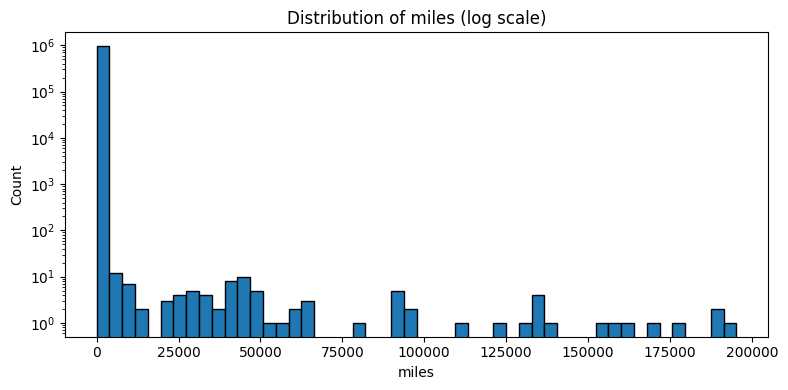

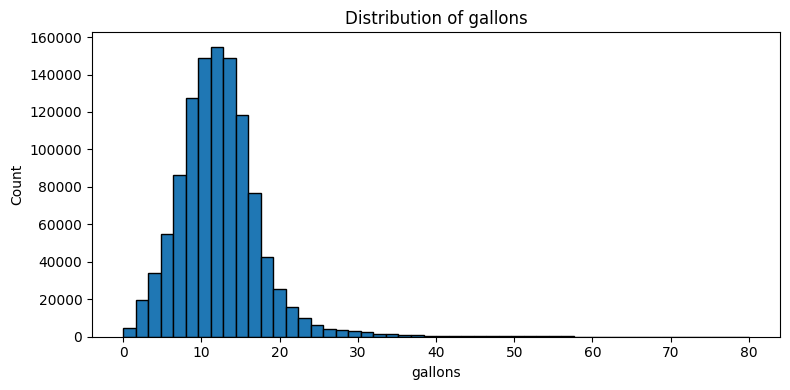

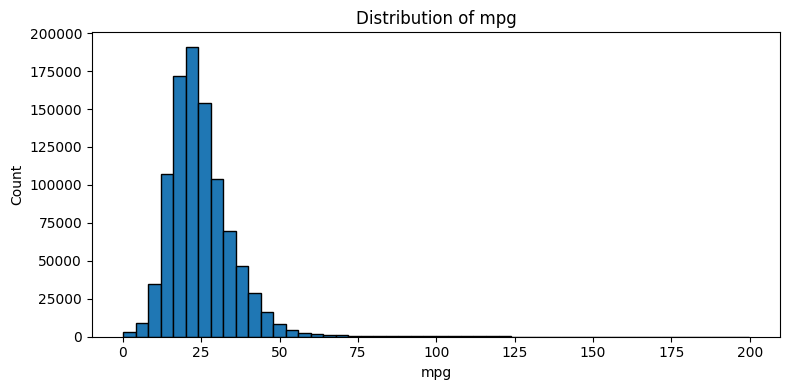

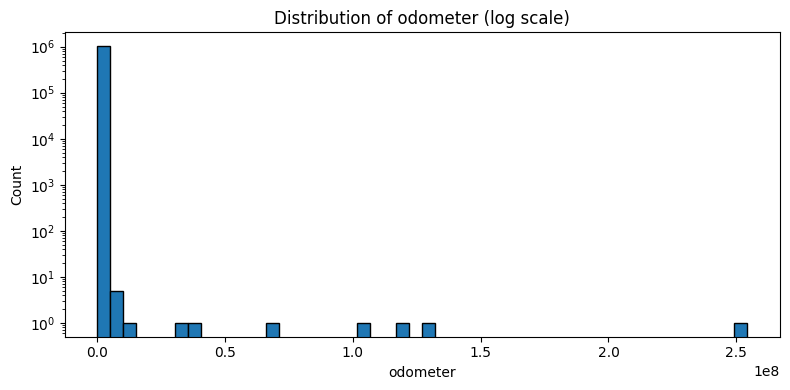

In [20]:
# 1.2.4 — Distribution plots for numeric columns
num_cols = [c for c in ['miles', 'gallons', 'mpg', 'odometer'] if c in derived_df.columns]

for col in num_cols:
    plt.figure(figsize=(8, 4))
    data = derived_df[col].dropna()

    # Use log scale if data is highly skewed
    if data.max() > 0 and data.median() > 0 and (data.max() / data.median()) > 50:
        plt.hist(data, bins=50, edgecolor="black", log=True)
        plt.yscale("log")
        plt.title(f"Distribution of {col} (log scale)")
    else:
        plt.hist(data, bins=50, edgecolor="black")
        plt.title(f"Distribution of {col}")

    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [22]:
# 1.2.5 — Statistical summary
stats = derived_df[num_cols].describe().T
stats["most_frequent"] = [derived_df[c].mode().iloc[0] if not derived_df[c].mode().empty else None for c in num_cols]

print("Statistical summary of numeric columns:")
display(stats)

# Simple interpretation helper: flag suspicious values
for col in num_cols:
    col_stats = stats.loc[col]
    print(f"\nColumn: {col}")
    print(f"  Mean = {col_stats['mean']:.2f}, Std = {col_stats['std']:.2f}")
    print(f"  Min = {col_stats['min']}, Max = {col_stats['max']}")
    print(f"  Median (50%) = {col_stats['50%']:.2f}")
    print(f"  Most frequent = {col_stats['most_frequent']}")

    # Quick sanity checks
    if col == "mpg" and col_stats["max"] > 100:
        print(" Warning: MPG above 100 detected (likely bad entry).")
    if col == "odometer" and col_stats["min"] < 0:
        print(" Warning: Negative odometer readings detected.")


Statistical summary of numeric columns:


,count,mean,std,min,25%,50%,75%,max,most_frequent
miles,957751.0,302.894495,757.284939,0.100,219.4671,283.7408,354.654,195321.2,300.000
gallons,1096941.0,12.319848,5.440403,0.001,8.9920,11.9530,14.933,80.0,10.567
mpg,962196.0,25.156547,11.619624,0.100,18.2000,23.3000,29.800,199.7,21.000
odometer,1023993.0,104001.372196,340798.478033,0.000,45926.0000,91882.0000,146923.000,254362100.0,1.000



Column: miles
  Mean = 302.89, Std = 757.28
  Min = 0.1, Max = 195321.2
  Median (50%) = 283.74
  Most frequent = 300.0

Column: gallons
  Mean = 12.32, Std = 5.44
  Min = 0.001, Max = 80.0
  Median (50%) = 11.95
  Most frequent = 10.567

Column: mpg
  Mean = 25.16, Std = 11.62
  Min = 0.1, Max = 199.7
  Median (50%) = 23.30
  Most frequent = 21.0

Column: odometer
  Mean = 104001.37, Std = 340798.48
  Min = 0.0, Max = 254362100.0
  Median (50%) = 91882.00
  Most frequent = 1.0


In [23]:
# Commit imputed values back to main dataframe
df = derived_df.copy()
